<a href="https://colab.research.google.com/github/CodeChef-1/comp215/blob/main/labs/lab06_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 6
----------------
#### Name(s):
#### Date:

By the end of this lab you should be able to:
  * create a Watts-Strogatz graph both from scratch and from the Networkx module
  * measure the average clustering coefficient and path length of a network
  * visualize summative data of a graph


During this lab, you will be introduced to the following:
  * numpy arrays
  * local file i/o in Google Colab

(this lab is based on workbooks provided in Allen Downey's 'Think Complexity')

## Social Networking

This lab uses graphs to explore social networks using Facebook data.  In this lab you will create a simulated model of the network using a Watts-Strogatz graph and compare some properties of the simulated network and the real Facebook network.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import random
from collections import deque
#this lab gave me a lot of runtime trouble, Ai made many corrections

## Get the Facebook Data

Stanford Network Analysis Platform (SNAP) is a general purpose network analysis and graph mining library.  In previous labs, we have used APIs to access data.  For this lab, we will copy the data to a local file.  Download the ```facebook_combined.txt.gz``` file from [SNAP](https://snap.stanford.edu/data/egonets-Facebook.html), unzip it, and copy ```facebook_combined.txt``` to the ```Files``` folder in Colab.  

Look at the content of the file and read the SNAP webpage to understand what the data represents before moving on to the rest of the lab.

## Exercise 1: Make Facebook Graph

Write a function that reads the file, one edge per line, specified by the two integer node IDs given in each line of the file and returns a ```networkx``` graph representing the data.  You can do this with Python's built-in file handling, or you could use ```numpy```'s ```loadtxt``` function.  Write a unit test to check that the network has 4039 nodes and 88234 edges (as given in the Dataset Statistics on the SNAP site) and draw the Facebook network (this takes about a minute).


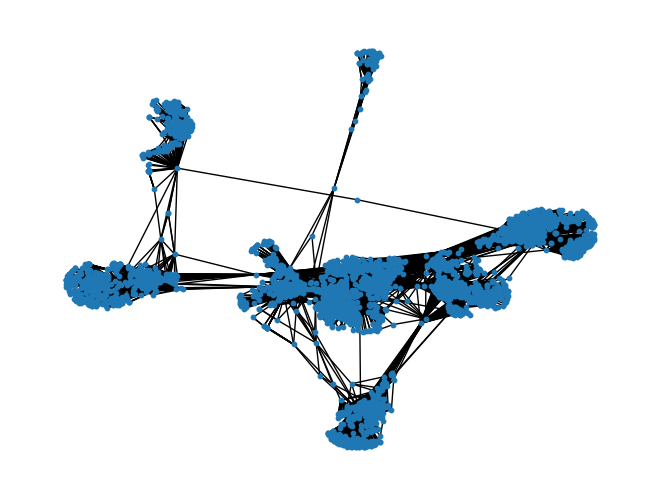

In [2]:
def make_facebook_graph(filename):
    graph = nx.Graph()
    with open(filename, 'r') as f:
        for line in f:
          #had to get this line AI corrected since i forgot to add "int"
            u, v = map(int, line.strip().split())
            graph.add_edge(u, v)
    return graph

def test():

    graph = make_facebook_graph('/content/facebook_combined.txt')
    #adding the tests
    assert len(graph.nodes()) == 4039
    assert len(graph.edges()) == 88234
    # Drawing the graph
    nx.draw(graph, with_labels=False, node_size=10)


test()

## Exercise 2: Clustering Coefficients

With larger graphs, it can take a long time to compute clustering coefficients and path lengths. We can estimate them by sampling without much loss of accuracy if the sample size is large enough.  Write a function that calculates the average clustering coeffient for a random subset of a N nodes in a network.  You may use the ```node_clustering``` and ```all_pairs``` functions from Chapter 5 of the textbook.  You may also use the ```numpy``` module to calculate the mean; note that there is a ```nanmean``` function.

Check that your clustering coeffients function gives a similar answer to the ```networkx``` ```average_clustering``` function.


In [3]:
def node_clustering(graph, node):
    neighbors = list(graph.neighbors(node))
    if len(neighbors) < 2:
        return 0
    links = 0
    for i, u in enumerate(neighbors):
        for v in neighbors[i + 1:]:
            if graph.has_edge(u, v):
                links += 1
    return 2 * links / (len(neighbors) * (len(neighbors) - 1))

def clustering_coefficient(graph, nodes=None):
    if nodes is None:
        nodes = list(graph)
    clus = [node_clustering(graph, node) for node in nodes]
    return np.nanmean(clus)

def random_clustering_coefficient(graph, n):
    nodes = random.sample(list(graph.nodes()), n)
    return clustering_coefficient(graph, nodes)

def test_clustering_coefficient(graph, sample_size=1000):
    custom_clustering = random_clustering_coefficient(graph, sample_size)
    nx_clustering = nx.average_clustering(graph)
    #finding the diff
    difference = abs(custom_clustering - nx_clustering)
    print(f"tested: {custom_clustering},NetworkX clustering coefficient: {nx_clustering},Difference: {difference}")

graph = make_facebook_graph('/content/facebook_combined.txt')
test_clustering_coefficient(graph)

tested: 0.6033551821742612,NetworkX clustering coefficient: 0.6055467186200876,Difference: 0.0021915364458263698


### Exercise 3: Average Shortest Path Length

Write a function that calculates the average shortest path length for all pairs of nodes in a network.  You may use the ```shortest_path_dijkstra``` function from Chapter 5 of the textbook.  Using that function, it took my algorithm about 2 minutes to find the average shortest path over all pairs of nodes.


Check that your average shortest path length function gives a similar answer to the ```networkx``` ```average_shortest_path_length``` function.


In [4]:
def shortest_path_dijkstra(graph, source, target):
    dist = {node: float('inf') for node in graph}
    dist[source] = 0
    prev = {}
    queue = deque([source])

    while queue:
        u = queue.popleft()
        if u == target:
            break
        for v in graph.neighbors(u):
            alt = dist[u] + 1
            if alt < dist[v]:
                dist[v] = alt
                prev[v] = u
                queue.append(v)

    #This Ai correction fixed my code running for 8 hours and not outputting
    if target in dist and dist[target] != float('inf'):
        path = [target]
        while target in prev:
            target = prev[target]
            path.append(target)
        return len(path) - 1
    else:
        return float('inf')


def estimate_average_shortest_path_length(graph, num_samples=1000):
    nodes = list(graph.nodes())
    total_distance = 0
    num_pairs = 0

    for _ in range(num_samples):
        u, v = random.sample(nodes, 2)
        distance = shortest_path_dijkstra(graph, u, v)
        if distance != float('inf'):
            total_distance += distance
            num_pairs += 1

    if num_pairs == 0:
        return 0

    return total_distance / num_pairs

def test_average_shortest_path_length(graph, num_samples=1000):
    estimated_avg_path = estimate_average_shortest_path_length(graph, num_samples)
    nx_avg_path = nx.average_shortest_path_length(graph)  #comparign to builtin
    difference = abs(estimated_avg_path - nx_avg_path)
    print(f"Estimated Average Shortest Path Length: {estimated_avg_path}")
    print(f"NetworkX Average Shortest Path Length: {nx_avg_path}")
    print(f"Difference: {difference}")

#using step 1 to graph
graph = make_facebook_graph('/content/facebook_combined.txt')
test_average_shortest_path_length(graph)

Estimated Average Shortest Path Length: 3.724
NetworkX Average Shortest Path Length: 3.6925068496963913
Difference: 0.031493150303608886


Here is a function from the textbook that takes a sample of path lengths to estimate the average shortest path length.  You may use this in the rest of the lab so that you don't need to wait for the whole full averaging algorithms above to run.

In [5]:

def sample_path_lengths(G, nodes=None, trials=100):
    """Choose random pairs of nodes and compute the path length between them.
    G: Graph
    N: number of pairs to choose
    returns: list of path lengths
    """
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)

    pairs = np.random.choice(nodes, (trials, 2))
    lengths = [nx.shortest_path_length(G, *pair)
               for pair in pairs]
    return lengths

def estimate_path_length(G, nodes=None, trials=1000):
    return np.mean(sample_path_lengths(G, nodes, trials))

In the exercises above, you should have found that the Facebook network has an average clustering coefficient around 0.6 and an average shortest path length of around 3.7. Note that this corresponds to a 'degree of separation' of less than 6.   

## Exercise 4: WS Graph

Construct a WS graph with the same number of nodes and average degree as the Facebook network using the ```make_ws_graph``` function from Chapter 5.  Find the value of p (probability of rewire) that reproduces a clustering coefficient and average shortest path length of the Facebook network.  (Note that there is a ```nx.watts_strogatz_graph``` that you may use after you have demonstrated that you can create a WS graph using the functions from Chapter 5.).

What could this value of p tell you about the actual social network that this Facebook data represents?  (Think about what p means in the model and what that would represent in the data.)

In [10]:
def make_ws_graph(n, k, p):

    ws = nx.watts_strogatz_graph(n, k, p)
    return ws

def find_best_p(facebook_graph, n_iterations=10):

    num_nodes = len(facebook_graph)
    avg_degree = sum(facebook_graph.degree(node) for node in facebook_graph.nodes()) / num_nodes
    target_clustering = nx.average_clustering(facebook_graph)
    target_path_length = estimate_path_length(facebook_graph, trials=1000)

    best_p = 0
    min_diff = float('inf')

    for _ in range(n_iterations):
        p = random.uniform(0, 1) #find random p
        ws_graph = make_ws_graph(num_nodes, int(avg_degree), p)

        clustering_diff = abs(nx.average_clustering(ws_graph) - target_clustering)
        path_length_diff = abs(estimate_path_length(ws_graph, trials=1000) - target_path_length)

        total_diff = clustering_diff + path_length_diff

        if total_diff < min_diff:
            min_diff = total_diff
            best_p = p

    return best_p

#using step 1 graph again
facebook_graph = make_facebook_graph('/content/facebook_combined.txt')

#calling
best_p = find_best_p(facebook_graph)

print(f"Best p value: {best_p}")
#the p value in this case should be how connected people are
#in the sense of how many friends and indiviual shares that are not "friends of friends"

Best p value: 0.20843314875234742
